<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/test_zarr_remote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus climate project

https://github.com/Vizzuality/copernicus-climate-data

`Edward P. Morris (vizzuality.)`

## Description
This notebook demonstrates functions to calculate heat wave frequency using cloud optimised ZARR datasets.

```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

## Linux dependencies

In [4]:
!apt install -q -y libspatialindex-dev libproj-dev proj-data proj-bin libgeos-dev

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
libspatialindex-dev is already the newest version (1.8.5-5).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## Python packages

In [5]:
!pip install -q xclim gcsfs zarr geopandas rioxarray netcdf4 nc-time-axis cftime regionmask

     |████████████████████████████████| 501kB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=4.5.0, but you'll have tornado 6.0.4 which is incompatible.


In [6]:
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.9.0          
affine                        2.3.0          
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.0.1          
asciitree                     0.3.3          
asgiref                       3.2.5          
astor                         0.8.1          
astropy                       4.0            
atari-py                      0.2.6          
atomicwrites                  1.3.0          
attrs                         19.3.0         
audioread                     2.1.8          
autograd                      1.3            
Babel                         2.8.0          
backcall                      0.1.0          
backports.tempfile            1.0            
backports.weakref             1.0.post1      
beautifulsoup4                4.6.3          
bleach                        3.1.

## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "skydipper-196010"
#!gcloud config set project {project_id}

In [0]:
# Copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/skydipper-196010-f842645fd0f3.json" "/root/.skydipper-196010-f842645fd0f3.json"

In [9]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris@skydipper-196010.iam.gserviceaccount.com \
          --key-file=/root/.skydipper-196010-f842645fd0f3.json --project="skydipper-196010"


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


To take a quick anonymous survey, run:
  $ gcloud survey



In [10]:
# Test GC auth
!gsutil ls "gs://copernicus-climate"

gs://copernicus-climate/RH_ERA5.zip
gs://copernicus-climate/RH_ERA5_2.zip
gs://copernicus-climate/mrt_ERA5-HEAT.zip
gs://copernicus-climate/sp_ERA5.zip
gs://copernicus-climate/spain.zarr.zip
gs://copernicus-climate/t2m_ERA5.zip
gs://copernicus-climate/variables_futuro_CMIP5_AEMET.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_3.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_4.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_3.zip
gs://copernicus-climate/ws_ERA5.zip
gs://copernicus-climate/dataset/
gs://copernicus-climate/ref-nuts-2016-01m.zarr/
gs://copernicus-climate/spain.zarr/


In [0]:
# Clean up
!rm -r sample_data

# Utils

## get_cached_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(
    display_style='html',
    display_width= 80,
    warn_for_unclosed_files=True,
    keep_attrs=False)


def get_cached_remote_zarr(
    group,
    root,
    project_id = "skydipper-196010",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #store = zarr.ZipStore(store, mode='r')
  cache = zarr.LRUStoreCache(store, max_size=None)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

## get_gda_geoms

In [0]:
import geopandas as gpd
import shapely

def get_gda_geoms(group, select_by=None, root = "copernicus-climate/ref-nuts-2016-01m.zarr"):
  gda = get_cached_remote_zarr(group, root = root)
  # Select
  if select_by:
    gda = gda.sel(select_by, drop=True)
  df = gda.reset_coords().to_dataframe().dropna().reset_index()
  geoms = df.geometry
  # Return as geopandas object, converting geometry to shapley objects
  return gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g, True) for g in geoms])


## get_mask

In [0]:
import geopandas as gpd
import shapely

def get_mask(group, select_by=None, root = "copernicus-climate/ref-nuts-2016-01m.zarr"):
  gda = get_cached_remote_zarr(group, root = root)
  # Select
  if select_by:
    gda = gda.sel(select_by, drop=True)
  df = gda.reset_coords().to_dataframe().dropna().reset_index()
  geoms = df.geometry
  # Return as geopandas object, converting geometry to shapley objects
  return gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g, True) for g in geoms])


## area_wt_mean

In [0]:
import shapely


def area_wt_mean(ds, vars, id_prop, mask):
  da = (ds[vars] * ds.area_km2).groupby(ds[mask]).sum()
  area = ds.area_km2.groupby(ds[mask]).sum().rename("total_area")
  da = (da / area)\
  .rename( dict(zip(vars, [f"{var}_mean" for var in vars])))
  id_ints = da[mask].values.astype(numpy.int64) 
  id_codes = ds[mask].attrs['id_codes']
  id_codes = [id_codes[i] for i in id_ints]
  da = da.rename({mask:id_prop})
  da = da.assign_coords({id_prop:id_codes})
  return da.chunk({id_prop:-1})

## monthly_heatwave_frequency

In [0]:
import xclim as xc
import xarray as xr

def monthly_heat_wave_frequency(ds, thresh_tasmax, thresh_tasmin, window):
  return xc.atmos.heat_wave_frequency(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')


## future_monthly_heat_wave_frequency

+ Future seasonal and long-term 
+ Dimensions are experiment (long-term), model, realisation, lat, lon, time 

In [0]:
def future_monthly_heat_wave_frequency(ds, thresh_tasmax='30 degC', thresh_tasmin='26 degC', window=2):
  return ds.groupby('model', 'realization')\
  .map(monthly_heat_wave_frequency, args=(thresh_tasmax, thresh_tasmin, window))\
  .mean(['model', 'realization']).squeeze()

## historical_monthly_heat_wave_frequency

+ Dimensions are lat, lon, time

In [0]:
def historical_monthly_heat_wave_frequency(ds, thresh_tasmax='30 C', thresh_tasmin='26 C', window=2):
  return monthly_heat_wave_frequency(ds, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window).squeeze()


## get_timeseries

In [0]:
import nc_time_axis
import cftime

def get_timeseries(ds, lat, lon, type, experiment=None, time_interval=None, thresh_tasmax='15 C', thresh_tasmin='5 C', window=2):
  # select point
  dss = ds.sel(lat=lat, lon=lon, method='nearest').chunk({"time":-1})
  if time_interval:
    dss = dss.sel(time=slice(time_interval[0], time_interval[1]))
  if type == 'future':
    if experiment:
      dss = dss.sel(experiment=experiment)
      out = future_monthly_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
    else:
      out = future_monthly_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)  
  if type== 'historical':  
    out = historical_monthly_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
  return out


## as_json

In [0]:
import json
from dateutil.tz import tzutc

def serialize_date(dt):
    """
    Serialize a date/time value into an ISO8601 text representation
    adjusted (if needed) to UTC timezone.

    For instance:
    >>> serialize_date(datetime(2012, 4, 10, 22, 38, 20, 604391))
    '2012-04-10T22:38:20.604391Z'
    """
    UTC = tzutc()
    try:
      if dt.tzinfo:
        dt = dt.astimezone(UTC).replace(tzinfo=None)
    except:
      pass    

    return dt.isoformat() + 'Z'

def as_json(ds):
  ds['time'] = ds.indexes['time'].to_datetimeindex() 
  d = ds.to_dict()
  d['coords']['time']['data'] = [serialize_date(dt) for dt in d['coords']['time']['data']]
  return json.dumps(d) 


## get raster

In [0]:
def get_raster(ds, time, type, experiment=None, bbox=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3):
  # select bbox
  if bbox:
    ds = ds.sel(lat=slice(bbox[0], bbox[2]), lon=slice(bbox[1], bbox[3]))
  # select time
  dss = ds.sel(time=time).chunk({"lat":-1, "lon":-1})
  if type == 'future':
    if experiment:
      dss = dss.sel(experiment=experiment)
    out = future_monthly_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)  
  if type== 'historical':  
    out = historical_monthly_heat_wave_frequency(dss, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window)
  return out

## interpolate_mask_raster

In [0]:
def interpolate_mask_raster(ds_dest, ds_src, navalue):
  # get bounds
  lon = ds_src.lon.values
  lat = ds_src.lat.values
  lonmin = lon.min()
  latmin = lat.min()
  lonmax = lon.max()
  latmax = lat.max()
  # clip to bounds
  ds_dest = ds_dest.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))
  # interpolate
  out = ds_dest.interp(lat=ds_src['lat'], lon=ds_src['lon'])
  # return masked array
  return out.where(ds_src != navalue)

## create_cog

In [0]:
import rioxarray

def create_cog(ds, p, nodata):
  ds.rio.set_spatial_dims('lon', 'lat')
  ds.attrs['nodata'] = nodata
  ds.rio.to_raster(p, **{
        "driver": "GTiff",
        "interleave": "pixel",
        "tiled": True,
        "blockxsize": 512,
        "blockysize": 512,
        "compress": "LZA",
        })
  print(f"COG written to {p}")

## add_area

In [0]:
import numpy as np
import numpy.matlib
import xarray as xr
import rioxarray

def add_area(ds):
  """
  Add DataArrays of the area in km2 and area weight of each array cell

  """
  # get info
  lon = ds.lon.values
  lat = ds.lat.values
  xdim = len(lon)
  ydim = len(lat)
  lonmin = lon.min()
  latmin = lat.min()
  lonmax = lon.max()
  latmax = lat.max()
  xres = (lonmax - lonmin) / xdim
  yres = (latmax - latmin) / ydim 
  
  # create lats + yres
  lats = np.linspace(int(latmin), int(latmax) + yres, ydim + 1)
  
  # constants
  a = 6378137
  b = 6356752.3142

  # Degrees to radians
  lats = lats * np.pi/180

  # Intermediate vars
  e = np.sqrt(1-(b/a)**2)
  sinlats = np.sin(lats)
  zm = 1 - e * sinlats
  zp = 1 + e * sinlats

  # Distance between meridians
  q = yres/360
  # q = pix_width/360

  # Compute areas for each latitude in square km
  areas_to_equator = np.pi * b**2 * ((2*np.arctanh(e*sinlats) / (2*e) + sinlats / (zp*zm))) / 10**6
  areas_between_lats = np.diff(areas_to_equator)
  areas_cells = np.abs(areas_between_lats) * q
  areagrid = np.transpose(np.matlib.repmat(areas_cells, xdim, 1))
  
  # Sum total area
  #tot_area = np.sum(areagrid)

  # Add area in km2
  da = xr.DataArray(
      data=areagrid,
      name='area_km2',
      coords=[lat, lon],
      dims=['lat', 'lon'], 
      attrs=None, indexes=None, fastpath=False)
  # Add area_weight
  #ds['area_weight'] = ds['area_km2'] / tot_area
  
  return ds.assign({'area_km2': da.chunk({'lat':-1, 'lon':-1})})



## set_lat_lon_attrs

In [0]:
def set_lat_lon_attrs(ds):
  """ Set CF latitude and longitude attributes"""
  ds["lon"] = ds.lon.assign_attrs({
    'axis' : 'X',
     'long_name' : 'longitude',
      'standard_name' : 'longitude',
       'stored_direction' : 'increasing',
        'type' : 'double',
         'units' : 'degrees_east',
          'valid_max' : 360.0,
           'valid_min' : -180.0
           })
  ds["lat"] = ds.lat.assign_attrs({
    'axis' : 'Y',
     'long_name' : 'latitude',
      'standard_name' : 'latitude',
       'stored_direction' : 'increasing',
        'type' : 'double',
         'units' : 'degrees_north',
          'valid_max' : 90.0,
           'valid_min' : -90.0
           })
  return ds
  

## create_ds_mask

In [0]:
import regionmask
import xarray as xr
import rioxarray
import geopandas

def create_ds_mask(df, ds, id_prop, name_prop, name):
  # clip to bounding box of ds
  xmin = ds.lon.min().values.tolist()
  xmax = ds.lon.max().values.tolist()
  ymin = ds.lat.min().values.tolist()
  ymax = ds.lat.max().values.tolist()
  df = df.cx[xmin:xmax, ymin:ymax]
  # extract geoms, codes, names, and create code_ints
  id_ints = list(range(0,len(df)))
  id_names = list(df[name_prop])
  id_codes = list(df[id_prop])
  geoms = list(df.geometry.values[i] for i in range(0, len(df)))
  # create mask object
  m = regionmask.Regions(
    name = name,
    numbers = id_ints,
    names = id_names,
    abbrevs = id_codes,
    outlines = geoms)\
    .mask(ds)\
    .rename(name)
  # update da attributes
  m.attrs['id_ints'] = id_ints
  m.attrs['id_codes'] = id_codes  
  m.attrs['id_names'] = id_names
  m = set_lat_lon_attrs(m)
  return m
  

# Example processing using remote ZARRS

## Access ZARRs

In [27]:
%%time
# Here we are only reading the metadata!
seas = get_cached_remote_zarr("seasonal-original-single-levels", 'copernicus-climate/spain.zarr')
print(seas)

<xarray.Dataset>
Dimensions:                  (forecast_reference_time: 1, lat: 9, lon: 15, model: 6, realization: 51, time: 215)
Coordinates:
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 2019-10-01
  * lat                      (lat) float64 35.5 36.5 37.5 ... 41.5 42.5 43.5
  * lon                      (lon) float64 -9.5 -8.5 -7.5 -6.5 ... 2.5 3.5 4.5
  * model                    (model) object 'dwd-2' 'ukmo-14' ... 'ecmwf-5'
  * realization              (realization) int64 0 1 2 3 4 5 ... 46 47 48 49 50
  * time                     (time) object 2019-10-02 00:00:00 ... 2020-05-04 00:00:00
Data variables:
    tasmax                   (model, forecast_reference_time, realization, time, lat, lon) float64 dask.array<chunksize=(1, 1, 51, 215, 9, 15), meta=np.ndarray>
    tasmin                   (model, forecast_reference_time, realization, time, lat, lon) float64 dask.array<chunksize=(1, 1, 51, 215, 9, 15), meta=np.ndarray>
CPU times: user 145 ms, sys: 3.85 ms, t

In [28]:
%%time
# Here we are only reading the metadata!
fut = get_cached_remote_zarr("projections-cmip5-daily-single-levels", 'copernicus-climate/spain.zarr')
print(fut)

<xarray.Dataset>
Dimensions:      (experiment: 2, lat: 8, lon: 8, model: 5, realization: 1, time: 34310)
Coordinates:
  * experiment   (experiment) object 'rcp85' 'rcp45'
    height       (model) float64 dask.array<chunksize=(5,), meta=np.ndarray>
  * lat          (lat) float64 35.0 36.25 37.5 38.75 40.0 41.25 42.5 43.75
  * lon          (lon) float64 -9.375 -7.5 -5.625 -3.75 -1.875 0.0 1.875 3.75
  * model        (model) object 'BNU-ESM' 'MPI-ESM-MR' ... 'MPI-ESM-LR'
  * realization  (realization) int64 1
  * time         (time) object 2006-01-01 00:00:00 ... 2099-12-31 00:00:00
Data variables:
    tasmax       (model, experiment, time, lat, lon, realization) float64 dask.array<chunksize=(1, 1, 34310, 8, 8, 1), meta=np.ndarray>
    tasmin       (model, experiment, time, lat, lon, realization) float64 dask.array<chunksize=(1, 1, 34310, 8, 8, 1), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.4
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    c

In [29]:
%%time
# Here we are only reading the metadata!
his = get_cached_remote_zarr("reanalysis-era5-land", 'copernicus-climate/spain.zarr')
print(his)

<xarray.Dataset>
Dimensions:  (lat: 91, lon: 151, time: 14244)
Coordinates:
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2019-12-31
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(365, 91, 151), meta=np.ndarray>
CPU times: user 23.3 ms, sys: 773 µs, total: 24.1 ms
Wall time: 1.12 s


In [30]:
%%time
# Get NUTS level 3 geometries
nuts_gdf = get_gda_geoms('geo-data-array', select_by={'LEVL_CODE':3, 'ISO3_CODE': ['PRT', 'ESP', 'FRA']})
print(nuts_gdf.head())

  ISO3_CODE  ...                                           geometry
0       PRT  ...  MULTIPOLYGON (((-8.19011 42.13480, -8.19292 42...
1       PRT  ...  MULTIPOLYGON (((-8.05186 41.82061, -8.04515 41...
2       PRT  ...  MULTIPOLYGON (((-8.02341 41.69686, -8.01741 41...
3       PRT  ...  MULTIPOLYGON (((-8.77643 41.47197, -8.75399 41...
4       PRT  ...  MULTIPOLYGON (((-7.88437 41.88144, -7.89144 41...

[5 rows x 18 columns]
CPU times: user 773 ms, sys: 88.8 ms, total: 862 ms
Wall time: 15.7 s


In [31]:
%%time
nuts_mask = get_cached_remote_zarr('mask-array-0-1-deg', 'copernicus-climate/ref-nuts-2016-01m.zarr')
print(nuts_mask)

<xarray.Dataset>
Dimensions:   (lat: 1019, lon: 1319)
Coordinates:
  * lat       (lat) float64 -25.95 -25.85 -25.75 -25.65 ... 75.65 75.75 75.85
  * lon       (lon) float64 -69.95 -69.85 -69.75 -69.65 ... 61.65 61.75 61.85
Data variables:
    NUTS_0    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_1    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_2    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_3    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    area_km2  (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
CPU times: user 18.8 ms, sys: 890 µs, total: 19.7 ms
Wall time: 633 ms


## Calculate monthly heatwaves

FIXME: Why do there appear to be no heatwaves (using reasonable limits) in the historical data?

### Get time series at single point

CPU times: user 8.45 s, sys: 1.19 s, total: 9.64 s
Wall time: 32.4 s


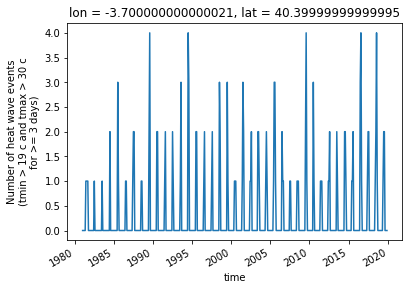

In [32]:
%%time
# Historical
ds = get_timeseries(his, 40.411335, -3.674908, 'historical', experiment=None, time_interval=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
ds.plot()

CPU times: user 1.55 s, sys: 111 ms, total: 1.66 s
Wall time: 3.86 s


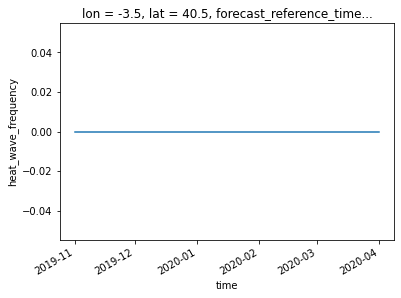

In [33]:
%%time
# Seasonal
ds = get_timeseries(seas, 40.411335, -3.674908, 'future', experiment=None, time_interval=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
# Fix for issue with plotting cftime
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds.plot()

CPU times: user 1min 12s, sys: 3.25 s, total: 1min 16s
Wall time: 1min 16s


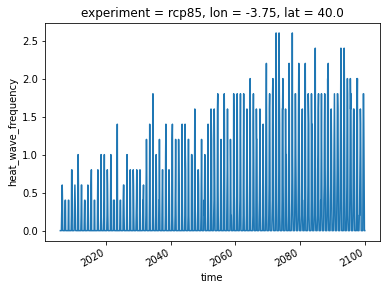

In [34]:
%%time
# this takes longer as it creates mean of n models and n realizations!
# Future
ds = get_timeseries(fut, 40.411335, -3.674908, 'future', experiment='rcp85', time_interval=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
# Fix for issue with plotting cftime
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds.plot()

In [35]:
# As JSON selecting time interval
%%time
import pprint
# Future
ds = get_timeseries(fut, 40.411335, -3.674908, 'future', experiment='rcp85', time_interval=['2090', '2091'], thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
pprint.pprint(as_json(ds))

('{"dims": ["time"], "attrs": {}, "data": [0.0, 0.0, 0.0, 0.0, 0.2, 0.8, 1.4, '
 '1.8, 1.2, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.8, 1.8, 1.8, 1.6, 0.8, '
 '0.0, 0.0], "coords": {"experiment": {"dims": [], "attrs": {}, "data": '
 '"rcp85"}, "lon": {"dims": [], "attrs": {"axis": "X", "bounds": "lon_bnds", '
 '"long_name": "longitude", "standard_name": "longitude", "stored_direction": '
 '"increasing", "type": "double", "units": "degrees_east", "valid_max": 360.0, '
 '"valid_min": -180.0}, "data": -3.75}, "lat": {"dims": [], "attrs": {"axis": '
 '"Y", "bounds": "lat_bnds", "long_name": "latitude", "standard_name": '
 '"latitude", "stored_direction": "increasing", "type": "double", "units": '
 '"degrees_north", "valid_max": 90.0, "valid_min": -90.0}, "data": 40.0}, '
 '"time": {"dims": ["time"], "attrs": {}, "data": ["2090-01-01T00:00:00Z", '
 '"2090-02-01T00:00:00Z", "2090-03-01T00:00:00Z", "2090-04-01T00:00:00Z", '
 '"2090-05-01T00:00:00Z", "2090-06-01T00:00:00Z", "2090-07-01T00:00:

### Get raster

CPU times: user 233 ms, sys: 20.6 ms, total: 254 ms
Wall time: 213 ms


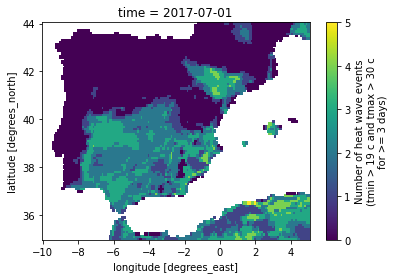

In [36]:
%%time
# Historical
ds = get_raster(his, '2017-07', 'historical', experiment=None, bbox=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
ds.plot()

CPU times: user 154 ms, sys: 2.95 ms, total: 157 ms
Wall time: 153 ms


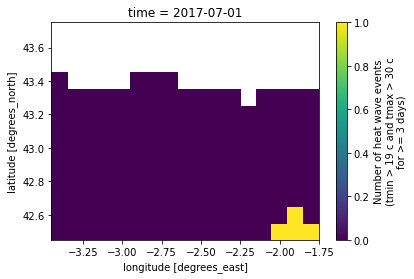

In [37]:
%%time
# Historical
nuts_gdf.loc[nuts_gdf['NAME_ENGL'] == '']
bbox = [42.4714,-3.4503,43.7598,-1.7293] #
ds = get_raster(his, '2017-07', 'historical', bbox=bbox, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
ds.plot()

COG written to ./test-cog.tif
Rsterio profile: {'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 151, 'height': 91, 'count': 1, 'crs': None, 'transform': Affine(0.09999999999999987, 0.0, -10.05,
       0.0, 0.10000000000000142, 34.949999999999875), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'interleave': 'band'}


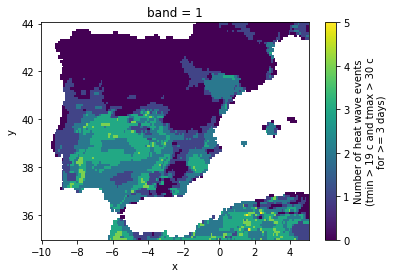

In [38]:
# Export a COG
# FIXME: rioxarray does not seem to read correctly?
import rioxarray
import rasterio
import xarray as xr
import numpy as np
from matplotlib import pyplot

# Get data array
ds = get_raster(his, '2010-08', 'historical', experiment=None, bbox=None, thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
#ds = get_raster(fut, '2090-08', 'future', experiment='rcp85')
#ds_src = get_raster(his, '2015-08', 'historical')
#ds = interpolate_mask_raster(ds, ds_src)

# Write as COG to file
cog_url = './test-cog.tif'
create_cog(ds, cog_url, np.nan)

# Check COG with rasterio
with rasterio.open('test-cog.tif') as src:
    print('Rsterio profile:', src.profile)
    #pyplot.imshow(src.read(1).T, cmap='pink')
    #pyplot.show()

# Open as data array
rds = xr.open_rasterio(cog_url)
rds.plot()





CPU times: user 5.67 s, sys: 1.54 s, total: 7.21 s
Wall time: 5.15 s


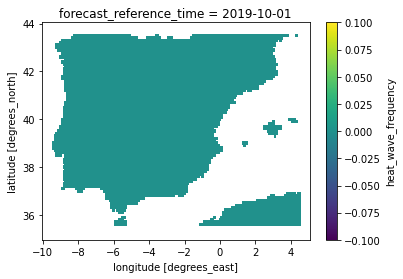

In [39]:
%%time
# Seasonal
ds = get_raster(seas, '2020-02', 'future')
ds_src = get_raster(his, '2015-08', 'historical')
ds = interpolate_mask_raster(ds, ds_src)
ds.plot()

CPU times: user 878 ms, sys: 27.6 ms, total: 905 ms
Wall time: 1.15 s


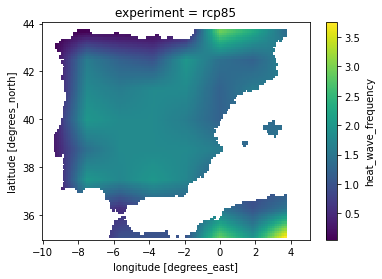

In [40]:
%%time
# Future
ds = get_raster(fut, '2090-08', 'future', experiment='rcp85')
ds_src = get_raster(his, '2015-08', 'historical')
ds = interpolate_mask_raster(ds, ds_src)
ds.plot()

# Example zonal stats 

Dataset:/n <xarray.Dataset>
Dimensions:                  (lat: 91, lon: 151)
Coordinates:
  * lon                      (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.8 4.9 5.0
  * lat                      (lat) float64 35.0 35.1 35.2 ... 43.8 43.9 44.0
Data variables:
    heat_wave_frequency_max  (lat, lon) float64 dask.array<chunksize=(91, 151), meta=np.ndarray>
    area_km2                 (lat, lon) float64 dask.array<chunksize=(91, 151), meta=np.ndarray>
<xarray.Dataset>
Dimensions:                  (lat: 91, lon: 151)
Coordinates:
  * lon                      (lon) float64 -10.0 -9.9 -9.8 -9.7 ... 4.8 4.9 5.0
  * lat                      (lat) float64 35.0 35.1 35.2 ... 43.8 43.9 44.0
    NUTS_3                   (lat, lon) float64 nan nan nan ... 79.0 90.0 90.0
Data variables:
    heat_wave_frequency_max  (lat, lon) float64 dask.array<chunksize=(91, 151), meta=np.ndarray>
    area_km2                 (lat, lon) float64 dask.array<chunksize=(91, 151), meta=np.ndarray>
<xarray.Dataset>
D

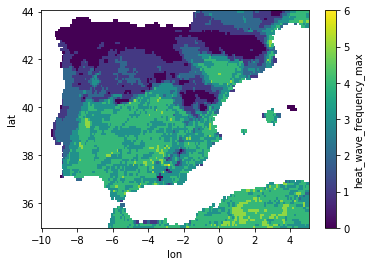

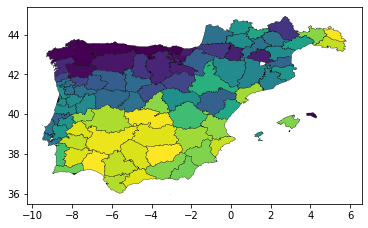

In [57]:
%%time
import xarray as xr
import pandas as pd

# Get dataset
da = get_raster(his, slice('2010', '2020'), 'historical', thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
da = da.max(dim='time').rename('heat_wave_frequency_max')

# Add area array to ds
ds = add_area(da.to_dataset())
print('Dataset:/n', ds)
ds.heat_wave_frequency_max.plot()

# Set NUTS admin level
level = 3


# Get NUTS geometries
tst = get_gda_geoms('geo-data-array', select_by={'LEVL_CODE':level, 'ISO3_CODE': ['PRT', 'ESP', 'FRA']})

# Mask array from geometries
tst_mask = create_ds_mask(tst, ds, 'NUTS_ID', 'NUTS_NAME', f"NUTS_{level}")

# Merge ds and mask
dsm = xr.merge([ds, tst_mask], join='left').set_coords(['lat', 'lon', f"NUTS_{level}"])
print(dsm)

# Area weighted mean of ds
ss = area_wt_mean(dsm, ['heat_wave_frequency_max'], 'NUTS_ID', f"NUTS_{level}")
print(ss)

# Merge results with geometries
out =  pd.merge(tst.set_index('NUTS_ID'), ss.to_dataframe().dropna(),  on='NUTS_ID', how='inner')

# Plot
out.plot(column='heat_wave_frequency_max_mean', linewidth=0.3, edgecolor="black")


Dataset:/n <xarray.DataArray 'heat_wave_frequency' (lat: 91, lon: 151)>
dask.array<nanmax-aggregate, shape=(91, 151), dtype=float64, chunksize=(91, 151), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -10.0 -9.9 -9.8 -9.7 -9.6 ... 4.6 4.7 4.8 4.9 5.0
  * lat      (lat) float64 35.0 35.1 35.2 35.3 35.4 ... 43.6 43.7 43.8 43.9 44.0
Mask;/n <xarray.Dataset>
Dimensions:   (lat: 1019, lon: 1319)
Coordinates:
  * lon       (lon) float64 -69.95 -69.85 -69.75 -69.65 ... 61.65 61.75 61.85
  * lat       (lat) float64 -25.95 -25.85 -25.75 -25.65 ... 75.65 75.75 75.85
Data variables:
    NUTS_3    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    area_km2  (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
CPU times: user 5.03 s, sys: 0 ns, total: 5.03 s
Wall time: 5.04 s


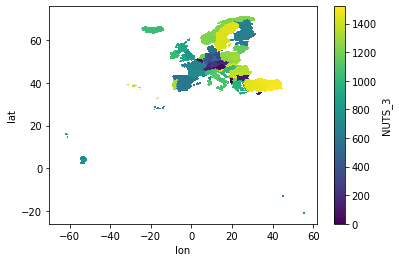

In [55]:
# make zonal stats using prebuilt NUTS mask
# FIXME the mask has to be the same grid as the dataset else we end up with issues!  
%%time
import xarray as xr
import pandas as pd
import numpy as np

# Get dataset
ds = get_raster(his, slice('2010', '2020'), 'historical', thresh_tasmax='30 C', thresh_tasmin='19 C', window=3)
ds = ds.max(dim='time')
print('Dataset:/n', ds)
#ds.plot()

# Clip and interpolate NUTS mask to dataset
nm = nuts_mask[['NUTS_3', 'area_km2']]#interpolate_mask_raster(nuts_mask[['NUTS_3', 'area_km2']], ds, np.nan)
print('Mask;/n', nm) 
nm.NUTS_3.plot()

# Merge ds and mask
#dsm = xr.merge([ds, nm], join='left').set_coords(['lat', 'lon', f"NUTS_3"])
#print('Merge:/n', dsm)

# Area weighted mean of ds
#ss = area_wt_mean(dsm, ['heat_wave_frequency'], 'NUTS_ID', f"NUTS_3")
#print('Zonal stats:', ss)

# Merge results with geometries
#out =  pd.merge(nuts_gdf.set_index('NUTS_ID'), ss.to_dataframe().dropna(),  on='NUTS_ID', how='inner').dropna()

# Plot
#out.plot(column='heat_wave_frequency_mean', linewidth=0.3, edgecolor="black")


In [0]:
# make zonal stats
import shapely


def area_weighted_mean_by_nut_level(ds, vars, level='NUTS_0'):
  da = (ds[vars] * ds.area_km2).groupby(ds[level]).sum()
  area = ds.area_km2.groupby(ds[level]).sum().rename("total_area")
  da = (da / area)\
  .rename( dict(zip(vars, [f"{var}_mean" for var in vars])))
  id_ints = da.coords[level].values.astype(numpy.int64) 
  id_codes = ds[level].attrs['id_codes']
  id_codes = [id_codes[i] for i in id_ints]
  da = da.rename({level:'NUTS_ID'})
  da = da.assign_coords({'NUTS_ID':id_codes})
  return da 

def area_weighted_mean_by_nuts(ds, var, levels=[0,1,2,3]):
  return xr.merge([area_weighted_mean_by_nut_level(ds, var, level=f"NUTS_{l}") for l in levels], compat='override')    

# Mean max temperature
tasmax = ds2.tasmax.groupby(ds2.NUTS_0).mean()
#print(tasmax.to_dict())

# Area weighted mean min and max temperature
ss = area_weighted_mean_by_nuts(ds2, ['tasmin', 'tasmax'])  
#ss

# Add geoms
nuts_ids = ss['NUTS_ID'].values.tolist()
print(nuts_ids)
geoms = gdf.loc[nuts_ids, 'geometry']
print(geoms)
wkb = [shapely.wkb.dumps(g, hex=True) for g in geoms]
ga = xr.DataArray(np.array(wkb), coords=[nuts_ids], dims=['NUTS_ID'], name='geometry')
ssg = xr.merge([ss, ga])
ssg




['ES', 'ES1', 'ES11', 'ES111', 'ES112', 'ES113', 'ES114', 'ES12', 'ES120', 'ES13', 'ES130', 'ES2', 'ES21', 'ES211', 'ES212', 'ES213', 'ES22', 'ES220', 'ES23', 'ES230', 'ES24', 'ES241', 'ES242', 'ES243', 'ES3', 'ES30', 'ES300', 'ES4', 'ES41', 'ES411', 'ES412', 'ES413', 'ES414', 'ES415', 'ES416', 'ES417', 'ES418', 'ES419', 'ES42', 'ES421', 'ES422', 'ES423', 'ES424', 'ES425', 'ES43', 'ES431', 'ES432', 'ES5', 'ES51', 'ES511', 'ES512', 'ES513', 'ES514', 'ES52', 'ES521', 'ES522', 'ES523', 'ES53', 'ES531', 'ES532', 'ES533', 'ES6', 'ES61', 'ES611', 'ES612', 'ES613', 'ES614', 'ES615', 'ES616', 'ES617', 'ES618', 'ES62', 'ES620', 'FR', 'FRI', 'FRI1', 'FRI13', 'FRI14', 'FRI15', 'FRJ', 'FRJ1', 'FRJ11', 'FRJ12', 'FRJ13', 'FRJ15', 'FRJ2', 'FRJ21', 'FRJ22', 'FRJ23', 'FRJ24', 'FRJ26', 'FRJ27', 'FRJ28', 'FRL', 'FRL0', 'FRL04', 'FRL06', 'PT', 'PT1', 'PT11', 'PT111', 'PT112', 'PT119', 'PT11A', 'PT11B', 'PT11C', 'PT11D', 'PT11E', 'PT15', 'PT150', 'PT16', 'PT16B', 'PT16D', 'PT16E', 'PT16F', 'PT16G', 'PT16H'

<xarray.Dataset>
Dimensions:      (NUTS_ID: 127)
Coordinates:
  * NUTS_ID      (NUTS_ID) object 'ES' 'ES1' 'ES11' ... 'PT185' 'PT186' 'PT187'
    time         datetime64[ns] 2015-08-15
Data variables:
    tasmin_mean  (NUTS_ID) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    tasmax_mean  (NUTS_ID) float64 dask.array<chunksize=(73,), meta=np.ndarray>
    geometry     (NUTS_ID) <U399750 '01060000006C0000000103000000010000009D1100006686A0297DC31EC0AEB27A63F2DF45409499B9E948C01EC07D9EFEEE03DF4540647F9FCFDBCB1EC062C2464F74DE45406BF69AB987CC1EC02476873F18DE45408EDCDDB175BA1EC060BBE59E8CDD45402ABD782619B31EC0A49CED0116DE4540231F3F9CEDAF1EC01F76D2DC99DF4540110938AD29A91EC0615683D0B3DF45400F63658C1F9B1EC03253488632DF45400E2452156D971EC0084E5C510DE04540C6E358AB068C1EC067D20D2C4CE045404D06035B1F861EC015D395FAA1DF45405FD2D66CD1851EC075054C2619DF454046495A44C5891EC00351027289DE454071A0D60162851EC0E7475AC5F3DD454028BA953792821EC03D90F5903FDC454017F20F320A741EC0EBD13BB193DB454076560359646D1EC0132C4104C4DB4540902BF4CBEA731EC0324708F433DA4540ADDBB302B5701EC0FC39161E89D945408C00CE5CFD6A1EC07B09A2D5C6D94540EDC08556DB6C1EC032B82C4DDAD845404746199BDB731EC094BFCD5311D84540AA9AA0364A741EC06085DA160AD745409925E2D9F96F1EC051B05F3650D64540FBD67FFDCD661EC0237C8D7A23D6454022AA41EB64611EC0C4AA120498D6454059266CC74C611EC0C10A51DF94D745407D587C8FD9541EC0903D793C29D84540C9C12824A0501EC01F2F8A5DABD8454060F8AED701581EC03ABB0B70D1DA4540B367C55E65541EC0844D3AAD1BDB45407EA32004AB4A1EC0155C56FE0ADB4540A733EA52633E1EC0C7E012F0F3DA4540EB70E9197B351EC016B3B47AC3DB45400551759112341EC0BCCFD170CFDC4540A3FF5D784C361EC037B790B565DD45403D900D64B42C1EC017B6BAF9ADDD45409E40FB448E221EC004B8022B63DD454005ED86EF53191EC03115567518DE45401DBD63E2780D1EC0AA2B77BBA8DC4540DF5589F9A6091EC07CECA020D7DC454086561470C0011EC08BCE23D199DC4540BE66DD3621F61DC0DA5859D10ADD454005C1319130ED1DC03B710AC8A6DC45404773502706E11DC06972CFB78FDC4540F63874E80EE41DC0B7454C3DA5DB454068685E04DCEA1DC07383C6DB0ADB454083499E9E77E31DC086E2789F38DA454080E0204BF6C41DC045C24A4A3FD945408FAEB404A6BE1DC06F83D36DB7D9454016E8CC13DCBC1DC06868CF9589D94540CE6D48817CBF1DC04053F147EBD84540D38693988BAD1DC0F103465275D845409A26F575B6A21DC02EDC97A832D84540BFD9F531BA941DC06B1F604709D74540F35B7A51F4801DC09063C21E68D6454039339C8AB8791DC0C7C2A7A28FD64540B7F7E345B86D1DC071679DBBD7D545408F49AC00FB6A1DC01A87891BF3D345409153A8B7065F1DC02CF0F9BC87D24540E58C561A865F1DC0E89A1C8238D2454097362B4D9A571DC01F5B59978DD145408729223766581DC0DC20FADBF0D045409EED1522F9531DC040F8FF745CD045403D7EA96B5B4C1DC0B153DF2E36D04540E806102CE4451DC0F20ECC2BA4CF4540B35DB4B7DD3E1DC003B1AE8305CF4540E5001E6686391DC0B031D441B5CD45402650D41D8F301DC0341670CB1FCD45409FA578891C2D1DC0573517EF41CC4540CA9CFF0DFA301DC067FD52F5EBCB4540EAD933F6E8201DC0133D7D899BCB4540BADA2B6E4D0C1DC08BED9E4E54CA45403D3D61D60AFE1CC094B7ACCAC5C94540BD5FAD649AFC1CC0B9AF0B4F77C945404F7DE1A50A041DC0E73A56C58BC84540C23AD164A00C1DC0C33FA1CF84C745401F40B45398031DC05BFCF1301BC745400AFEA4EDD10B1DC0DE92CAE07DC64540A194588B51051DC09F1FD3111FC64540203EF15085F91CC0B524B5EBB4C64540DDF04F5FABF91CC0A3734F5863C845403175F1DBC7F21CC05DC356C58BC8454037FFF5ACEFF01CC091841ACFB8C84540CD4F8721D1EB1CC0A98056C58BC845402BEA211A05E51CC020C3449531C84540B02C9C9C69CF1CC0C9658F25E5C74540214DFCC0EDB51CC04BFBF604EEC745406E23F5973BB01CC00E3DF52E42C74540098BE70297A71CC0017B90E106C74540258E6EB8B77A1CC0E9D9911808C74540241BB94F2E751CC0C626A7FDDDC745405FC810DC5C5C1CC0F446EE3C0CC74540E06F3CD18C551CC0557B2FFA3FC74540E70157B9BC4C1CC066628673E3C645402DF84C598B3B1CC05A0F87A781C7454048984A8CD52B1CC08B19DFEF03C7454076D8BC571E261CC02638978894C64540B4FF21038E241CC0CEF51868D6C545405A67EFE099201CC075A2EE3DB1C545402D0350555F161CC093EEA43955C645407AD63CE56E161CC0BF253DE8ABC645405CEAD917521C1CC0D9018F1640C745403B476665D6151CC07EAA302A93C745407F562EFCE0FC1BC02AB1265EF3C64540C5019E55F6E51BC086CA202866C7454094A71B2F9EDA1BC0A54CD36FD6C745402D178EBE36D51BC0349BC8EB0BC84540B2F699DD19C71BC038FF59F474C94540AE38421376BD1BC0163868E509C9454007E89B

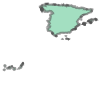

In [0]:
g = ssg.geometry.sel(NUTS_ID='ES').values.tolist()
shapely.wkb.loads(g, hex=True)
#ga.sel(NUTS_ID='ES').values.tolist())

## Create ZARR

In [0]:
import zarr
import xarray as xr

# Create zarr store structure
zarr_dir = 'spain.zarr'
store = ssg.chunk({'NUTS_ID':-1}).to_zarr(store=zarr_dir, group="ref-nuts-2016-01m_zonal-stats", mode="w", consolidated=True)
#unchunk_dataset(dataset_path=f"{zarr_dir}/ESP_3_reanalysis-era5-land", coords_only = True)
zarr.consolidate_metadata(zarr_dir)
root = zarr.open(zarr_dir, mode='r')
print(root.tree())

/
 ├── ref-nuts-2016-01m
 │   ├── CAPT (4, 37, 2016) object
 │   ├── CC_STAT (4, 37, 2016) object
 │   ├── CNTR_CODE (4, 37, 2016) object
 │   ├── EFTA_STAT (4, 37, 2016) object
 │   ├── EU_STAT (4, 37, 2016) object
 │   ├── ISO3_CODE (37,) object
 │   ├── LEVL_CODE (4,) int64
 │   ├── NAME_ASCI (4, 37, 2016) object
 │   ├── NAME_ENGL (4, 37, 2016) object
 │   ├── NAME_FREN (4, 37, 2016) object
 │   ├── NAME_GERM (4, 37, 2016) object
 │   ├── NAME_HTML (4, 37, 2016) object
 │   ├── NAME_LATN (4, 37, 2016) object
 │   ├── NUTS_ID (2016,) object
 │   ├── NUTS_NAME (4, 37, 2016) object
 │   ├── SVRG_UN (4, 37, 2016) object
 │   ├── Shape_Area (4, 37, 2016) float64
 │   ├── Shape_Length (4, 37, 2016) float64
 │   └── geometry (4, 37, 2016) object
 ├── ref-nuts-2016-01m_mask
 │   ├── NUTS_0 (91, 151) float64
 │   ├── NUTS_1 (91, 151) float64
 │   ├── NUTS_2 (91, 151) float64
 │   ├── NUTS_3 (91, 151) float64
 │   ├── area_km2 (91, 151) float64
 │   ├── lat (91,) float64
 │   └── lon (151,) 

## Check local ZARR

In [0]:
zonal_stats = xr.open_zarr(store=zarr_dir, group="ref-nuts-2016-01m_zonal-stats", consolidated=True)
zonal_stats

<xarray.Dataset>
Dimensions:      (NUTS_ID: 127)
Coordinates:
  * NUTS_ID      (NUTS_ID) object 'ES' 'ES1' 'ES11' ... 'PT185' 'PT186' 'PT187'
    time         datetime64[ns] ...
Data variables:
    geometry     (NUTS_ID) |S199875 dask.array<chunksize=(127,), meta=np.ndarray>
    tasmax_mean  (NUTS_ID) float64 dask.array<chunksize=(127,), meta=np.ndarray>
    tasmin_mean  (NUTS_ID) float64 dask.array<chunksize=(127,), meta=np.ndarray>

In [0]:
import numpy as np
import shapely
import pandas as pd
import geopandas as gpd

df = zonal_stats.to_dataframe()
gdf = gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g) for g in df.geometry])
gdf
#print(zonal_stats.tasmin_mean.sel(NUTS_ID=['ES', 'PT']).values.tolist())
#[shapely.wkb.loads(zonal_stats.geometry.sel(NUTS_ID=id).values.tolist()) for id in ['ES', 'PT']]

geometry  ...       time
NUTS_ID                                                     ...           
ES       MULTIPOLYGON (((-7.69091 43.74958, -7.68778 43...  ... 2015-08-15
ES1      MULTIPOLYGON (((-7.69091 43.74958, -7.68778 43...  ... 2015-08-15
ES11     MULTIPOLYGON (((-7.69091 43.74958, -7.68778 43...  ... 2015-08-15
ES111    MULTIPOLYGON (((-7.69091 43.74958, -7.68778 43...  ... 2015-08-15
ES112    MULTIPOLYGON (((-7.63098 43.74713, -7.63068 43...  ... 2015-08-15
...                                                    ...  ...        ...
PT181    MULTIPOLYGON (((-8.61535 38.55270, -8.58962 38...  ... 2015-08-15
PT184    MULTIPOLYGON (((-7.27824 38.32040, -7.26497 38...  ... 2015-08-15
PT185    MULTIPOLYGON (((-8.75938 39.47574, -8.75178 39...  ... 2015-08-15
PT186    MULTIPOLYGON (((-7.53615 39.66159, -7.53038 39...  ... 2015-08-15
PT187    MULTIPOLYGON (((-8.14609 39.02320, -8.13813 39...  ... 2015-08-15

[127 rows x 4 columns]

In [0]:
# Compare calcuated area

print(mask.NUTS_0.attrs)
ad = area.area_km2.to_dict()
print(ad['data'][0])

nuts.loc[(nuts['ISO3_CODE'] == 'ESP') & (nuts['LEVL_CODE'] == 0)].Shape_Area / 10**6

{'id_codes': ['ES', 'FR', 'PT'], 'id_ints': [0, 1, 2], 'id_names': ['ESPAÑA ', 'FRANCE', 'PORTUGAL']}
549840.2413880426


11    506003.917137
Name: Shape_Area, dtype: float64